# Développez un outil de prévision de la consommation d'énergie

Context: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.
This archive contains 2075259 measurements gathered between December 2006 and November 2010 (47 months).

Notes:
1.(globalactivepower*1000/60 - submetering1 - submetering2 - submetering3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.
2.The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.

Attribute Information:

1.date: Date in format dd/mm/yyyy<br>
2.time: time in format hh:mm:ss<br>
3.globalactivepower: household global minute-averaged active power (in kilowatt)<br>
4.globalreactivepower: household global minute-averaged reactive power (in kilowatt)<br>
5.voltage: minute-averaged voltage (in volt)<br>
6.global_intensity: household global minute-averaged current intensity (in ampere)<br>
7.submetering1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).<br>
8.submetering2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.<br>
9.submetering3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# EDA

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')
from datetime import datetime
import seaborn as sns

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import SimpleRNN

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import math

In [195]:
data = pd.read_csv('data/household_power_consumption.txt', 
                   sep=';',
                   #parse_dates={'Datetime' : ['Date', 'Time']},
                   #infer_datetime_format=True,
                   na_values=['nan','?'],
                   #index_col='Datetime'
                  )

In [196]:
def all_info(df):
    print("-------------Top-5--------------")
    print(df.head())
    print()
    print("-----------Information-----------")
    print(df.info())
    print()
    print("-----------Data Types-----------")
    print(df.dtypes)
    print()
    print("----------Missing value-----------")
    print(df.isnull().sum())
    print()
    print("----------Null value-----------")
    print(df.isna().sum())
    print()
    print("----------Shape of Data----------")
    print(df.shape)
    print("----------Duplicate----------")
    print(df.duplicated().sum())

In [197]:
all_info(data)

-------------Top-5--------------
         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  

-----------Information-----------
<class 'pandas.core.frame.DataF

In [198]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [199]:
# keep only columns that I need
data = data[['Date', 'Time', 'Global_active_power']]
data.head()

,Date,Time,Global_active_power
0,16/12/2006,17:24:00,4.216
1,16/12/2006,17:25:00,5.360
2,16/12/2006,17:26:00,5.374
3,16/12/2006,17:27:00,5.388
4,16/12/2006,17:28:00,3.666


In [200]:
# split date
data[["day", "month", "year"]] = data["Date"].str.split("/", expand = True)

In [201]:
data.head()

,Date,Time,Global_active_power,day,month,year
0,16/12/2006,17:24:00,4.216,16,12,2006
1,16/12/2006,17:25:00,5.360,16,12,2006
2,16/12/2006,17:26:00,5.374,16,12,2006
3,16/12/2006,17:27:00,5.388,16,12,2006
4,16/12/2006,17:28:00,3.666,16,12,2006


In [202]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


In [203]:
df = data

# new df for datetime (column date + time)
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# set index Datetime
df.set_index('Datetime', inplace=True)

In [205]:
df.head()

,Date,Time,Global_active_power,day,month,year
Datetime,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,16,12,2006
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,16,12,2006
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,16,12,2006
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,16,12,2006
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,16,12,2006


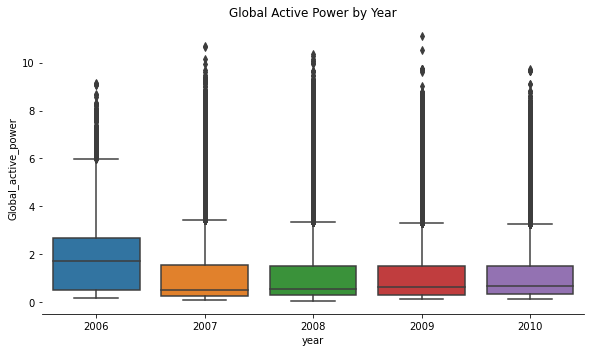

In [206]:
# boxplot by years
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year", y="Global_active_power", data=data)
plt.xlabel('year')
plt.title('Global Active Power by Year')
sns.despine(left=True)
plt.tight_layout() 

Sur le boxplot, en 2006, la médiane est plus élevée que les autres années, sauf que nous avons que les données du mois de décembre pour 2006 et cela correspond d'ailleurs aux pics de conso d'energie constaté en hiver, même les autres années.

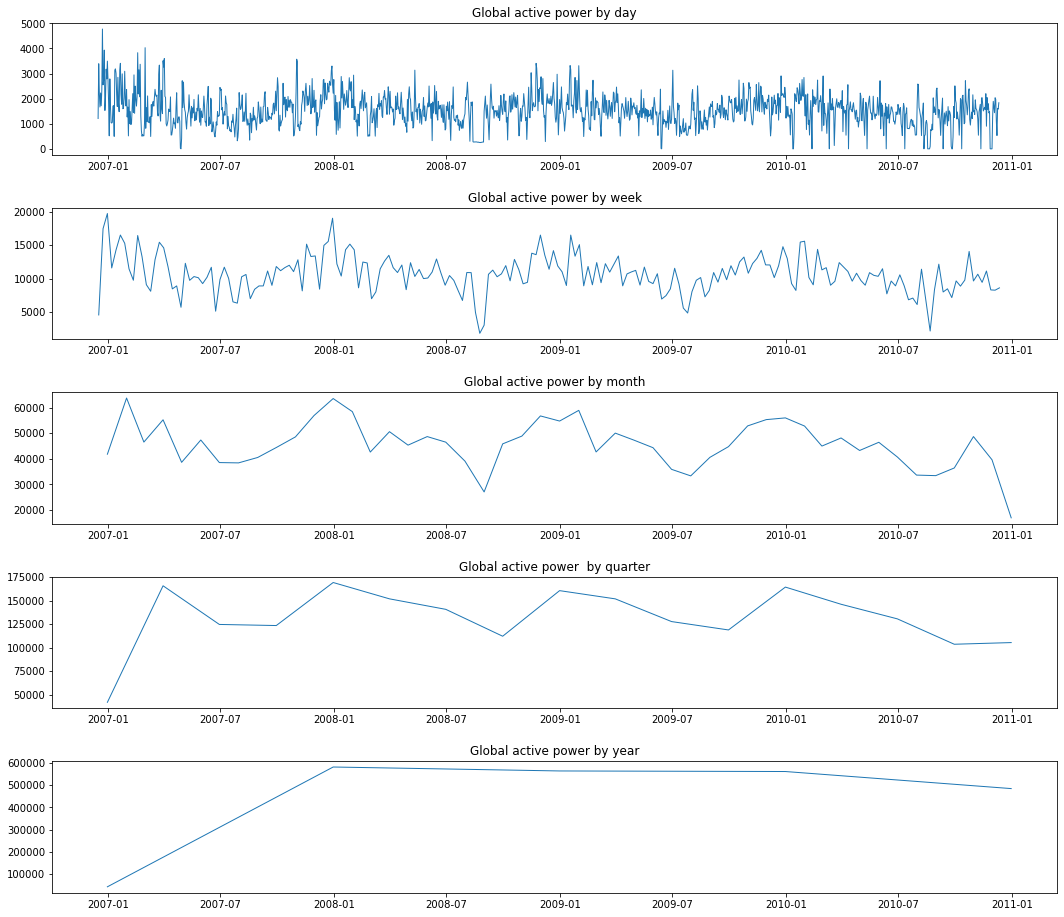

In [207]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df['Global_active_power'].resample('D').sum(),linewidth=1)
ax1.set_title('Global active power by day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df['Global_active_power'].resample('W').sum(),linewidth=1)
ax2.set_title('Global active power by week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df['Global_active_power'].resample('M').sum(),linewidth=1)
ax3.set_title('Global active power by month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df['Global_active_power'].resample('Q').sum(),linewidth=1)
ax4.set_title('Global active power  by quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df['Global_active_power'].resample('A').sum(),linewidth=1)
ax5.set_title('Global active power by year')
ax5.tick_params(axis='both', which='major');

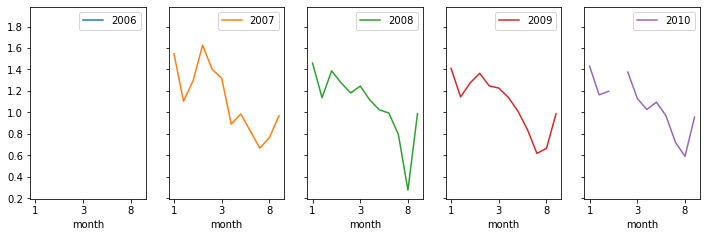

In [208]:
# plot by years
pd.pivot_table(df.loc[df['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);